# Logistic Regression

It is a predictive algorithm using independent variables to predict the dependent variable, just like Linear Regression, but with a difference that the dependent variable should be categorical variable.

Independent variables can be numeric or categorical variables, but the dependent variable will always be categorical

Logistic Regression can be used for binary classification or multi-class classification.

Binary classification is when we have two possible outcomes like a person is infected with COVID-19 or is not infected with COVID-19. In multi-class classification, we have multiple outcomes like the person may have the flu or an allergy, or cold or COVID-19.

Assumptions for Logistic Regression No outliers in the data. An outlier can be identified by analyzing the independent variables No correlation (multi-collinearity) between the independent variables.

Unlike linear regression which outputs continuous number values, logistic regression uses the logistic sigmoid function to transform its output to return a probability value which can then be mapped to two or more discrete classes.

# check thr different multi_class= options avaible in sklearn

multi_class{‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’

In [3]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
from sklearn.linear_model import LogisticRegression # for building a logistic regression model
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from imblearn.over_sampling import RandomOverSampler # for oversampling / undersampling
import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization

In [4]:
# Read in the csv
df=pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/Chess_Data.csv', encoding='utf-8')
# Print the first few columns 
df.iloc[:,:12]

id  rated    created_at  last_move_at  turns victory_status  \
0      TZJHLljE  False  1.500000e+12  1.500000e+12     13      outoftime   
1      l1NXvwaE   True  1.500000e+12  1.500000e+12     16         resign   
2      mIICvQHh   True  1.500000e+12  1.500000e+12     61           mate   
3      kWKvrqYL   True  1.500000e+12  1.500000e+12     61           mate   
4      9tXo1AUZ   True  1.500000e+12  1.500000e+12     95           mate   
...         ...    ...           ...           ...    ...            ...   
20053  EfqH7VVH   True  1.499790e+12  1.499790e+12     24         resign   
20054  WSJDhbPl   True  1.499700e+12  1.499700e+12     82           mate   
20055  yrAas0Kj   True  1.499700e+12  1.499700e+12     35           mate   
20056  b0v4tRyF   True  1.499700e+12  1.499700e+12    109         resign   
20057  N8G2JHGG   True  1.499640e+12  1.499640e+12     78           mate   

      winner increment_code       white_id  white_rating            black_id  \
0      white           15+2       bourgris          1500                a-00   
1      black           5+10           a-00          1322           skinnerua   
2      white           5+10         ischia          1496                a-00   
3      white           20+0  daniamurashov          1439        adivanov2009   
4      white           30+3      nik221107          1523        adivanov2009   
...      ...            ...            ...           ...                 ...   
20053  white          10+10        belcolt          1691            jamboger   
20054  black           10+0       jamboger          1233  farrukhasomiddinov   
20055  white           10+0       jamboger          1219        schaaksmurf3   
20056  white           10+0   marcodisogno          1360            jamboger   
20057  black           10+0       jamboger          1235               ffbob   

       black_rating  
0              1191  
1              1261  
2              1500  
3              1454  
4              1469  
...             ...  
20053          1220  
20054          1196  
20055          1286  
20056          1227  
20057          1339  

[20058 rows x 12 columns]

As we will want to use the ‘winner’ field for our dependent (target) variable, let’s check the distribution of it:

In [5]:
df['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

It is good to see that the wins between white and black are quite balanced. However, a small minority of matches ended up in a draw. Having an underrepresented class will make it harder to predict it, which we will see the multinomial examples later.

For the binary outcome model, we will try to predict whether the white pieces will win using the player rating difference. Meanwhile, for the multinomial case, we will attempt to predict all three classes (white win, draw, black win).

First, let’s derive a few new fields for usage in model predictions.

In [6]:
# Difference between white rating and black rating - independent variable
df['rating_difference']=df['white_rating']-df['black_rating']

# White wins flag (1=win vs. 0=not-win) - dependent (target) variable
df['white_win']=df['winner'].apply(lambda x: 1 if x=='white' else 0)

# Match outcome (1=white wins, 0=draw, -1=black wins) - dependent (target) variable for multinomial regression
df['match_outcome']=df['winner'].apply(lambda x: 1 if x=='white' else 
                                       0 if x=='draw' else -1)

# Check by printing last few cols in a dataframe
df.iloc[:,13:]

opening_eco                            opening_name  opening_ply  \
0             D10        Slav Defense: Exchange Variation            5   
1             B00  Nimzowitsch Defense: Kennedy Variation            4   
2             C20   King's Pawn Game: Leonardis Variation            3   
3             D02  Queen's Pawn Game: Zukertort Variation            3   
4             C41                        Philidor Defense            5   
...           ...                                     ...          ...   
20053         A80                           Dutch Defense            2   
20054         A41                            Queen's Pawn            2   
20055         D00         Queen's Pawn Game: Mason Attack            3   
20056         B07                            Pirc Defense            4   
20057         D00         Queen's Pawn Game: Mason Attack            3   

       rating_difference  white_win  match_outcome  
0                    309          1              1  
1                     61          0             -1  
2                     -4          1              1  
3                    -15          1              1  
4                     54          1              1  
...                  ...        ...            ...  
20053                471          1              1  
20054                 37          0             -1  
20055                -67          1              1  
20056                133          1              1  
20057               -104          0             -1  

[20058 rows x 6 columns]

# Logistic regression for a binary outcome — 1 independent variable

Let’s start building! We will use the difference between white and black ratings as the independent variable and the ‘white_win’ flag as the target.

After splitting the data into train and test samples, we fit the model. We chose sag (stochastic average gradient) solver for finding beta parameters of the log-odds equation this time. As listed in the comments below, there are other solvers, which we will try in the next few examples.

In [7]:

# Select data for modeling
X=df['rating_difference'].values.reshape(-1,1)
y=df['white_win'].values

# Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
# Note, solvers available: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
model = LogisticRegression(solver='sag')
clf = model.fit(X_train, y_train)

# Predict class labels on a test data
LR1_pred_labels = model.predict(X_test)

# Print slope and intercept
print('Intercept (Beta 0): ', clf.intercept_)
print('Slope (Beta 1): ', clf.coef_)

Intercept (Beta 0):  [-0.00392547]
Slope (Beta 1):  [[0.00360908]]


Let’s check our model performance metrics on the test sample:

In [8]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print('Accuracy Score: ', score)
print('--------------------------------------------------------')
# Look at classification report to evaluate the model
print(classification_report(y_test, LR1_pred_labels))

Accuracy Score:  0.6440677966101694
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2024
           1       0.64      0.64      0.64      1988

    accuracy                           0.64      4012
   macro avg       0.64      0.64      0.64      4012
weighted avg       0.64      0.64      0.64      4012



We can see that while the model is not great, it still helps us to identify the white win in 64% of the cases, which is better than a random guess (a 50% chance of getting it right).

Next, let’s plot a Logistic function with each class mapped onto it. We will do some data preparation first:

In [9]:
# Predict probabilities for each class label on test data
probs=model.predict_proba(X_test)
#probs[:,1]

# This is for plottling logistic function
# Create 100 evenly spaced points from smallest X to largest X
X_range = np.linspace(X.min(), X.max(), 100)
# Predict probabilities for each class label
y_range = model.predict_proba(X_range.reshape(-1, 1))

# Create a boolean array for masking data (needed for graph)
mask_0 = y_test < 0.5   
mask_1 = y_test > 0.5 
print(y_test)
#print(mask_0)
print(mask_1)

[1 1 0 ... 0 1 0]
[ True  True False ... False  True False]


We will use masking in the graph to create two separate traces, one with events (white won) and the other with non-events (white did not win). As you can see, it is simply a boolean array contain True for 1 and False for 0.

In [10]:

# Create a scatter plot
fig = px.scatter(df, x=X_test.ravel(), y=y_test, 
                 opacity=0.8, color_discrete_sequence=['black'],
                 labels=dict(x="Rating Points Difference Between White and Black", y="Predicted Probability for White Win",))

# Add additional traces
fig.add_traces(go.Scatter(x=X_test.ravel()[mask_1], y=probs[:,1][mask_1]+0.01, name='White won', mode = 'markers', opacity=0.9, marker=dict(color='limegreen')))
fig.add_traces(go.Scatter(x=X_test.ravel()[mask_0], y=probs[:,1][mask_0]-0.01, name='White did not win', mode = 'markers', opacity=0.9, marker=dict(color='red')))
fig.add_traces(go.Scatter(x=X_range, y=y_range[:,1], name='Logistic Function', line=dict(color='black')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title=dict(text="Binary Logistic Regression (1 Independent Variable) Model Results", 
                             font=dict(color='black')))
# Update marker size
fig.update_traces(marker=dict(size=7))

fig.show()

Let’s take a look at what is displayed here.

The black dots at the top are the test dataset observations with the actual class of 1 (white won). In comparison, the black dots at the bottom are observations with the actual class of 0 (white did not win).
The black line is the logistic function which is based on the equation we derived with our model giving us the following parameters:intercept = -0.00289864 and slope = 0.00361573.
Green dots are black dots with class=1 mapped onto the logistic function using the probabilities from the model.
Red dots are black dots with class=0 mapped onto the logistic function using the probabilities from the model.
Quick note, I had to offset green and red dots by a small amount (0.01) to avoid overlapping for easier reading.

In summary, while the model can correctly predict a white win in 64% of the cases {p(white win)>0.5}, there are also lots of cases (36%) where it did not predict the outcome successfully. This suggests that having a higher rating in chess does not guarantee success in a match.

# Logistic regression for a binary outcome — 2 independent variables

et’s add an additional independent variable to the next model. We will use a field called ‘turns,’ which tells us the total number of moves made in a match.

Note that we are somewhat cheating here as the number of total moves would only be known after the match. Hence, this data point would not be available to us if we were to make a prediction before the match starts. Nevertheless, this is for illustration purposes only, so we will go ahead and use it anyway.

In [11]:
# Select data for modeling
X=df[['rating_difference', 'turns']]
y=df['white_win'].values

# Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
# Note, solvers available: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
model = LogisticRegression(solver='lbfgs')
clf = model.fit(X_train, y_train)

# Predict class labels on a test data
LR2_pred_labels = model.predict(X_test)

# Print slope and intercept
print('Intercept (Beta 0): ', clf.intercept_)
print('Slopes (Beta 1 and Beta 2): ', clf.coef_)

Intercept (Beta 0):  [0.23038895]
Slopes (Beta 1 and Beta 2):  [[ 0.00361403 -0.0043553 ]]


Note that we have two slope parameters this time, one for each independent variable. β(2) is slightly negative, suggesting that a higher number of ‘turns’ indicates a lower chance of white winning. This makes sense as the white not winning also includes ‘draws,’ and they are more likely to occur after a long match (after many moves).

In [12]:

# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print('Accuracy Score: ', score)
print('--------------------------------------------------------')
# Look at classification report to evaluate the model
print(classification_report(y_test, LR2_pred_labels))

Accuracy Score:  0.6622632103688934
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2024
           1       0.67      0.63      0.65      1988

    accuracy                           0.66      4012
   macro avg       0.66      0.66      0.66      4012
weighted avg       0.66      0.66      0.66      4012



We can see that all classification metrics have improved for this model with 66% correct predictions. Not a surprise, given we used the ‘turns’ field, which gives us information about how the match has evolved.

Let’s now do some data prep and plot a logistic function again, although this time, it will be a surface on a 3D graph instead of a line. It is because we used 2 independent variables in our model.

In [13]:
# Predict probabilities for each class label on test data
probs=model.predict_proba(X_test)
#probs[:,1]

# --------- This is for plottling logistic function plane --------
# Increments between points in a meshgrid
mesh_size = 10
# How much to extend beyond min and max values (optional)
margin = 0

# Identify min and max values for input variables
x_min, x_max = X_test['rating_difference'].min() - margin, X_test['rating_difference'].max() + margin
y_min, y_max = X_test['turns'].min() - margin, X_test['turns'].max() + margin

# Return evenly spaced values based on a range between min and max
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)

# Create a meshgrid
xx, yy = np.meshgrid(xrange, yrange)

# Use models to create a prediciton plane - Logistic Regression
pred_LR = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
pred_LR = pred_LR[:,1].reshape(xx.shape)

# Note, .ravel() flattens the array to a 1D array,
# then np.c_ takes elements from flattened xx and yy arrays and puts them together,
# this creates the right shape required for model input

# prediction array that is created by the model output is a 1D array,
# Hence, we need to reshape it to be the same shape as xx or yy to be able to display it on a graph

# --------- Create a boolean array for masking data (needed for graph) -------- 
mask_0 = y_test < 0.5   
mask_1 = y_test > 0.5 
#print(y_test)
#print(mask_0)
#print(mask_1)

C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



In [14]:
# Create a 3D scatter plot with predictions
fig = px.scatter_3d(df, x=X_test['rating_difference'], y=X_test['turns'], z=y_test, 
                 opacity=0.8, color_discrete_sequence=['black'],
                 labels=dict(x="Rating Points Difference Between White and Black", 
                             y="Number of Turns",
                             z="Predicted Probability for White Win",))

# Set figure title and colors
fig.update_layout(title_text="Scatter 3D Plot with LR Prediction Surface",
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'
                                          ),
                               zaxis=dict(backgroundcolor='white',
                                          color='black', 
                                          gridcolor='lightgrey')))
# Update marker size
fig.update_traces(marker=dict(size=3))

# Add prediction plane
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred_LR, name='LR Prediction',
                          colorscale=px.colors.sequential.Sunsetdark))

fig.add_traces(go.Scatter3d(x=X_test['rating_difference'][mask_1], y=X_test['turns'][mask_1], z=probs[:,1][mask_1], 
                            name='White won', showlegend=False, mode = 'markers', opacity=0.9, marker=dict(color='limegreen', size=3)))
fig.add_traces(go.Scatter3d(x=X_test['rating_difference'][mask_0], y=X_test['turns'][mask_0], z=probs[:,1][mask_0], 
                            name='White did not win', showlegend=False, mode = 'markers', opacity=0.9, marker=dict(color='blue', size=3)))

fig.show()

This graph shows how the black dots at the top (class=1) and the bottom (class=0) have been mapped onto the logistic function prediction surface. In this case, green dots show probabilities for class=1 and blue ones for class=0.

# Multinomial logistic regression — 2 independent variables

Let’s now build a model that has 3 class labels:

-1: black wins
0: draw
1: white wins

In [15]:

# Select data for modeling
X=df[['rating_difference', 'turns']]
# Match outcome (-1=black wins, 0=draw, 1=white wins)
y=df['match_outcome'].values

# Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
# Note, solvers available: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
model = LogisticRegression(solver='newton-cg', max_iter=1000)
clf = model.fit(X_train, y_train)

# Predict class labels on a test data
LR3_pred_labels = model.predict(X_test)

# Print slope and intercept - note each class will have its own equation
# Order: (-1=black wins, 0=draw, 1=white wins)
print('Intercepts (Beta 0s): ', clf.intercept_)
print('Slopes (Beta 1s and Beta 2s): ')
print(clf.coef_)

Intercepts (Beta 0s):  [ 1.08540058 -2.37515846  1.28975788]
Slopes (Beta 1s and Beta 2s): 
[[-0.00208595 -0.00527959]
 [ 0.00031227  0.0126069 ]
 [ 0.00177368 -0.00732731]]


Note that for a multinomial case, we have three intercepts and 3 pairs of slopes. This is because the model creates a separate equation for predicting each class.

In [16]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print('Accuracy Score: ', score)
print('--------------------------------------------------------')
# Look at classification report to evaluate the model
print(classification_report(y_test, LR3_pred_labels))

Accuracy Score:  0.6308574277168495
--------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.63      0.60      0.61      1849
           0       0.43      0.02      0.03       175
           1       0.63      0.71      0.67      1988

    accuracy                           0.63      4012
   macro avg       0.56      0.44      0.44      4012
weighted avg       0.62      0.63      0.62      4012



As expected, the model had some difficulty predicting class=0 (draw) due to the unbalanced data. You can see a lot fewer draw outcomes (175 in the test sample) than wins by either white or black.

Based on precision, we can see that the model got 43% of its ‘draw’ predictions right. However, the recall is only 0.02, meaning that there were very few cases where the model predicted a ‘draw’ with most of the ‘draw’ outcomes being unidentified.

There are multiple ways of dealing with unbalanced data, with one approach being to oversample the minority class (in this case, class=0).

# Multinomial logistic regression with oversampling — 2 independent variables

In [17]:
# Select data for modeling
X=df[['rating_difference', 'turns']]
# Match outcome (-1=black wins, 0=draw, 1=white wins)
y=df['match_outcome'].values

# Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# This will oversample the minority class (draw) to match majority classes in the training data
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

# Fit the model
# Note, solvers available: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
model = LogisticRegression(solver='newton-cg', max_iter=1000)
clf = model.fit(X_over, y_over)

# Predict class labels on a test data
LR4_pred_labels = model.predict(X_test)

# Print slope and intercept - note each class will have its own equation
# Order: (-1=black wins, 0=draw, 1=white wins)
print('Intercepts (Beta 0s): ', clf.intercept_)
print('Slopes (Beta 1s and Beta 2s): ')
print(clf.coef_)

Intercepts (Beta 0s):  [ 0.27951375 -0.74883618  0.46932243]
Slopes (Beta 1s and Beta 2s): 
[[-0.0020557  -0.00489991]
 [ 0.00040808  0.01157007]
 [ 0.00164761 -0.00667017]]


In [18]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print('Accuracy Score: ', score)
print('--------------------------------------------------------')
# Look at classification report to evaluate the model
print(classification_report(y_test, LR4_pred_labels))

Accuracy Score:  0.5244267198404786
--------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.67      0.47      0.56      1849
           0       0.10      0.58      0.17       175
           1       0.67      0.57      0.61      1988

    accuracy                           0.52      4012
   macro avg       0.48      0.54      0.45      4012
weighted avg       0.65      0.52      0.57      4012



These are the final results. We can see that the model accuracy has gone down due to a reduction in precision for class=0. This is expected with oversampling as the model expects the class to be much more common than it actually is, leading to more frequent predictions of a ‘draw.’

While this harmed precision, it has helped with recall as the model was able to identify more of the ‘draw’ outcomes.

Clearly, this model is far from ideal and more work is needed to improve it. This can be done by adding more independent variables and employing additional techniques such as undersampling majority classes.

However, the purpose of these examples was to show you how you can build different types of logistic regression models rather than finding the best model for this specific set of data.

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
import numpy as np

# create data
x = np.linspace(-10, 10, 100)

# get sigmoid output
y = sigmoid(x)

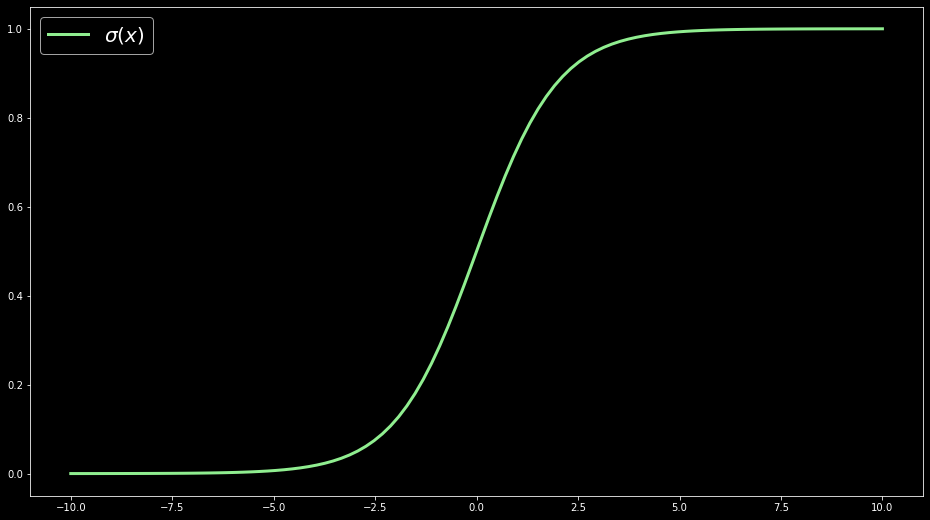

In [22]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

fig = plt.figure(figsize=(16, 9))

plt.plot(x, y, c="lightgreen", linewidth=3.0, label="$\sigma(x)$")
plt.legend(prop={'size': 20})
plt.show()

Our example problem will simulate a class of students and test outcomes to determine whether hours spent learning can predict a pass or fail.

We'll create a variable, called hours_spent_learning, to predict the outcome of a binary variable, pass_test ("passed" = 1, "failed" = 0).

In [23]:
# create variable used for prediction
hours_spent_learning = np.linspace(1, 100, 100)

# probability of passing
weights = hours_spent_learning / len(hours_spent_learning)

In [24]:
# create variable we want to predict from hours_spent_learning
#values between 0 and 1. 
#if the weight is more than 0,5 it goes for 1, if it is less it goes for 0. 
pass_test = np.random.binomial(1, weights)

In [25]:
#see that we have more ones (1) at the end, it makes sense since we have more hours_spent_learning
pass_test 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
print('First five values')
print('\thours_spent_learning:\t', hours_spent_learning[:5])
print('\tweights:\t\t', weights[:5])
print('\tpass_test:\t\t', pass_test[:5])

First five values
	hours_spent_learning:	 [1. 2. 3. 4. 5.]
	weights:		 [0.01 0.02 0.03 0.04 0.05]
	pass_test:		 [0 0 0 0 0]


In [28]:
print('Last five values')
print('\thours_spent_learning:\t', hours_spent_learning[95:])
print('\tweights:\t\t', weights[95:])
print('\tpass_test:\t\t', pass_test[95:])

Last five values
	hours_spent_learning:	 [ 96.  97.  98.  99. 100.]
	weights:		 [0.96 0.97 0.98 0.99 1.  ]
	pass_test:		 [1 1 1 1 1]


In [29]:
x = hours_spent_learning.reshape(-1, 1)

In [30]:
y = pass_test

In [31]:
# fit the model
model = LogisticRegression()
model.fit(x, y)

LogisticRegression()

In [32]:
print(model.coef_)

[[0.05004477]]


In [33]:
model.intercept_

array([-2.3502132])

In [34]:
(y == 1).ravel()

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True, False, False,  True, False, False,
       False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True, False,  True,  True, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [35]:
# use the model coefficients to draw the plot
pred = sigmoid(x * model.coef_[0] + model.intercept_[0])

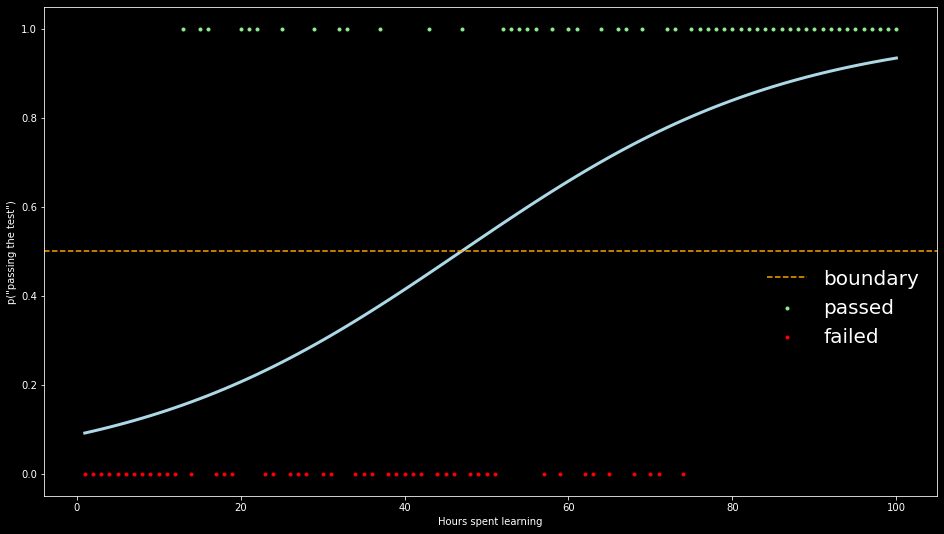

In [36]:
fig = plt.figure(figsize=(16, 9))
plt.plot(x, pred, c="lightblue", linewidth=3.0)
plt.scatter(
    x[(y == 1).ravel()],
    y[(y == 1).ravel()],
    marker=".",
    c="lightgreen",
    linewidth=1.0,
    label="passed",
)
plt.scatter(
    x[(y == 0).ravel()],
    y[(y == 0).ravel()],
    marker=".",
    c="red",
    linewidth=1.0,
    label="failed",
)
plt.axhline(y=0.5, color="orange", linestyle="--", label="boundary")
plt.xlabel("Hours spent learning")
plt.ylabel('p("passing the test")')
plt.legend(frameon=False, loc="best", bbox_to_anchor=(0.5, 0.0, 0.5, 0.5), prop={'size': 20})
plt.show()

# it is important to denote that y is probability of passing the test.

# Check the density of the dots. Green dots are more when more hours of learning are spent and more density which makes sense with the threshold of probability > 0.5.


Using the decision boundary denoted by the orange line, we can also use the fitted model to predict if a person will pass or fail the test based on the hours spent learning. The convention here is to classify "pass" if the predicted probability is higher than 0.5 or "fail" if lower.

In [37]:
model.predict([[18]]) 

array([0])

In [38]:
model.predict([[30]])  # 30 hours spent learning will lead to a fail prediction

array([0])

In [39]:
model.predict([[60]])  # 60 hours spent learning will lead to a pass prediction

array([1])

For instance, say the prediction function returns a value of 0.8, this would get classified as true/positive (as it is above the selected value of threshold). A value of 0.3, on the other hand, would get classified as false/negative. When dealing with multivariate logistic regression, we select the class with the highest predicted probability.

# Multinomial Logistic Regression

In [40]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#for chapter 3.2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt

In [41]:
iris = pd.read_csv("C:/Users/Admin/Machine Learning chapter 5/iris.csv")

In [42]:
iris

5.1  3.5  1.4  0.2     Iris-setosa
0    4.9  3.0  1.4  0.2     Iris-setosa
1    4.7  3.2  1.3  0.2     Iris-setosa
2    4.6  3.1  1.5  0.2     Iris-setosa
3    5.0  3.6  1.4  0.2     Iris-setosa
4    5.4  3.9  1.7  0.4     Iris-setosa
..   ...  ...  ...  ...             ...
144  6.7  3.0  5.2  2.3  Iris-virginica
145  6.3  2.5  5.0  1.9  Iris-virginica
146  6.5  3.0  5.2  2.0  Iris-virginica
147  6.2  3.4  5.4  2.3  Iris-virginica
148  5.9  3.0  5.1  1.8  Iris-virginica

[149 rows x 5 columns]

In [43]:
# adding column name to the respective columns
iris.columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width','species']

In [44]:
iris

sepal_length  sepal_width  petal_length  petal_width         species
0             4.9          3.0           1.4          0.2     Iris-setosa
1             4.7          3.2           1.3          0.2     Iris-setosa
2             4.6          3.1           1.5          0.2     Iris-setosa
3             5.0          3.6           1.4          0.2     Iris-setosa
4             5.4          3.9           1.7          0.4     Iris-setosa
..            ...          ...           ...          ...             ...
144           6.7          3.0           5.2          2.3  Iris-virginica
145           6.3          2.5           5.0          1.9  Iris-virginica
146           6.5          3.0           5.2          2.0  Iris-virginica
147           6.2          3.4           5.4          2.3  Iris-virginica
148           5.9          3.0           5.1          1.8  Iris-virginica

[149 rows x 5 columns]

In [45]:
x = iris.drop('species', axis=1)
y = iris['species']
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2)

In [46]:
#3 categories. 
y.value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        49
Name: species, dtype: int64

In [47]:
#fit the model. 
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
log_reg.fit(trainX, trainY)
y_pred = log_reg.predict(testX)

In [48]:
#model validation. 
print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(testY, y_pred)))

Accuracy: 0.97
Error rate: 0.03


# Calculated probabilities

In [49]:
probability = log_reg.predict_proba(testX)
probability

array([[9.68720291e-01, 3.12796247e-02, 8.41978037e-08],
       [9.62968154e-01, 3.70315838e-02, 2.62043633e-07],
       [6.74220855e-05, 6.05102128e-02, 9.39422365e-01],
       [1.64254341e-05, 2.05485828e-02, 9.79434992e-01],
       [9.83427515e-01, 1.65724367e-02, 4.82968165e-08],
       [2.83055929e-05, 7.12448891e-02, 9.28726805e-01],
       [3.62229951e-06, 2.93294982e-02, 9.70666879e-01],
       [3.10867816e-04, 1.63711534e-01, 8.35977599e-01],
       [9.71554393e-01, 2.84455473e-02, 5.93118311e-08],
       [9.35828998e-01, 6.41707286e-02, 2.73465703e-07],
       [9.76529103e-01, 2.34707878e-02, 1.08890064e-07],
       [9.42741806e-01, 5.72575207e-02, 6.73580905e-07],
       [9.42948545e-03, 9.16828943e-01, 7.37415716e-02],
       [9.70778608e-01, 2.92212539e-02, 1.38159195e-07],
       [9.82301078e-01, 1.76988817e-02, 4.04212682e-08],
       [8.56990290e-04, 5.65162595e-01, 4.33980415e-01],
       [1.63428210e-01, 8.31823263e-01, 4.74852631e-03],
       [9.69742403e-01, 3.02575

Each column here represents a class. The class with the highest probability is the output of the predicted class. Here we can see that the length of the probability data is the same as the length of the test data.

In [51]:
print(probability.shape)#3 classses
print(testX.shape) #4 features

(30, 3)
(30, 4)


In [52]:
df = pd.DataFrame(log_reg.predict_proba(testX), columns=log_reg.classes_)
df.head(20)

Iris-setosa  Iris-versicolor  Iris-virginica
0      0.968720         0.031280    8.419780e-08
1      0.962968         0.037032    2.620436e-07
2      0.000067         0.060510    9.394224e-01
3      0.000016         0.020549    9.794350e-01
4      0.983428         0.016572    4.829682e-08
5      0.000028         0.071245    9.287268e-01
6      0.000004         0.029329    9.706669e-01
7      0.000311         0.163712    8.359776e-01
8      0.971554         0.028446    5.931183e-08
9      0.935829         0.064171    2.734657e-07
10     0.976529         0.023471    1.088901e-07
11     0.942742         0.057258    6.735809e-07
12     0.009429         0.916829    7.374157e-02
13     0.970779         0.029221    1.381592e-07
14     0.982301         0.017699    4.042127e-08
15     0.000857         0.565163    4.339804e-01
16     0.163428         0.831823    4.748526e-03
17     0.969742         0.030258    6.805596e-08
18     0.018139         0.923443    5.841888e-02
19     0.001272         0.769081    2.296469e-01

In [53]:
df['sum'] = df.sum(axis=1)
df.head()

Iris-setosa  Iris-versicolor  Iris-virginica  sum
0     0.968720         0.031280    8.419780e-08  1.0
1     0.962968         0.037032    2.620436e-07  1.0
2     0.000067         0.060510    9.394224e-01  1.0
3     0.000016         0.020549    9.794350e-01  1.0
4     0.983428         0.016572    4.829682e-08  1.0

In [54]:
df['predicted_class'] = y_pred
df.head(20)

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class
0      0.968720         0.031280    8.419780e-08  1.0      Iris-setosa
1      0.962968         0.037032    2.620436e-07  1.0      Iris-setosa
2      0.000067         0.060510    9.394224e-01  1.0   Iris-virginica
3      0.000016         0.020549    9.794350e-01  1.0   Iris-virginica
4      0.983428         0.016572    4.829682e-08  1.0      Iris-setosa
5      0.000028         0.071245    9.287268e-01  1.0   Iris-virginica
6      0.000004         0.029329    9.706669e-01  1.0   Iris-virginica
7      0.000311         0.163712    8.359776e-01  1.0   Iris-virginica
8      0.971554         0.028446    5.931183e-08  1.0      Iris-setosa
9      0.935829         0.064171    2.734657e-07  1.0      Iris-setosa
10     0.976529         0.023471    1.088901e-07  1.0      Iris-setosa
11     0.942742         0.057258    6.735809e-07  1.0      Iris-setosa
12     0.009429         0.916829    7.374157e-02  1.0  Iris-versicolor
13     0.970779         0.029221    1.381592e-07  1.0      Iris-setosa
14     0.982301         0.017699    4.042127e-08  1.0      Iris-setosa
15     0.000857         0.565163    4.339804e-01  1.0  Iris-versicolor
16     0.163428         0.831823    4.748526e-03  1.0  Iris-versicolor
17     0.969742         0.030258    6.805596e-08  1.0      Iris-setosa
18     0.018139         0.923443    5.841888e-02  1.0  Iris-versicolor
19     0.001272         0.769081    2.296469e-01  1.0  Iris-versicolor

In [55]:
df['actual_class'] = testY.to_frame().reset_index().drop(columns='index')
df.head(20)

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class  \
0      0.968720         0.031280    8.419780e-08  1.0      Iris-setosa   
1      0.962968         0.037032    2.620436e-07  1.0      Iris-setosa   
2      0.000067         0.060510    9.394224e-01  1.0   Iris-virginica   
3      0.000016         0.020549    9.794350e-01  1.0   Iris-virginica   
4      0.983428         0.016572    4.829682e-08  1.0      Iris-setosa   
5      0.000028         0.071245    9.287268e-01  1.0   Iris-virginica   
6      0.000004         0.029329    9.706669e-01  1.0   Iris-virginica   
7      0.000311         0.163712    8.359776e-01  1.0   Iris-virginica   
8      0.971554         0.028446    5.931183e-08  1.0      Iris-setosa   
9      0.935829         0.064171    2.734657e-07  1.0      Iris-setosa   
10     0.976529         0.023471    1.088901e-07  1.0      Iris-setosa   
11     0.942742         0.057258    6.735809e-07  1.0      Iris-setosa   
12     0.009429         0.916829    7.374157e-02  1.0  Iris-versicolor   
13     0.970779         0.029221    1.381592e-07  1.0      Iris-setosa   
14     0.982301         0.017699    4.042127e-08  1.0      Iris-setosa   
15     0.000857         0.565163    4.339804e-01  1.0  Iris-versicolor   
16     0.163428         0.831823    4.748526e-03  1.0  Iris-versicolor   
17     0.969742         0.030258    6.805596e-08  1.0      Iris-setosa   
18     0.018139         0.923443    5.841888e-02  1.0  Iris-versicolor   
19     0.001272         0.769081    2.296469e-01  1.0  Iris-versicolor   

       actual_class  
0       Iris-setosa  
1       Iris-setosa  
2    Iris-virginica  
3    Iris-virginica  
4       Iris-setosa  
5    Iris-virginica  
6    Iris-virginica  
7    Iris-virginica  
8       Iris-setosa  
9       Iris-setosa  
10      Iris-setosa  
11      Iris-setosa  
12  Iris-versicolor  
13      Iris-setosa  
14      Iris-setosa  
15  Iris-versicolor  
16  Iris-versicolor  
17      Iris-setosa  
18  Iris-versicolor  
19  Iris-versicolor

Now we can do a plausibility check whether the classes were predicted correctly. Unfortunately, the comparison of two object columns works very badly in my test attempts. Therefore I built a small word around in which I convert the predicted_classes and actual_classes using the label encoder from scikit-learn and then continue to work with numerical values.

In [56]:
le = preprocessing.LabelEncoder()

df['label_pred'] = le.fit_transform(df['predicted_class'])
df['label_actual'] = le.fit_transform(df['actual_class'])
df.head(20)

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class  \
0      0.968720         0.031280    8.419780e-08  1.0      Iris-setosa   
1      0.962968         0.037032    2.620436e-07  1.0      Iris-setosa   
2      0.000067         0.060510    9.394224e-01  1.0   Iris-virginica   
3      0.000016         0.020549    9.794350e-01  1.0   Iris-virginica   
4      0.983428         0.016572    4.829682e-08  1.0      Iris-setosa   
5      0.000028         0.071245    9.287268e-01  1.0   Iris-virginica   
6      0.000004         0.029329    9.706669e-01  1.0   Iris-virginica   
7      0.000311         0.163712    8.359776e-01  1.0   Iris-virginica   
8      0.971554         0.028446    5.931183e-08  1.0      Iris-setosa   
9      0.935829         0.064171    2.734657e-07  1.0      Iris-setosa   
10     0.976529         0.023471    1.088901e-07  1.0      Iris-setosa   
11     0.942742         0.057258    6.735809e-07  1.0      Iris-setosa   
12     0.009429         0.916829    7.374157e-02  1.0  Iris-versicolor   
13     0.970779         0.029221    1.381592e-07  1.0      Iris-setosa   
14     0.982301         0.017699    4.042127e-08  1.0      Iris-setosa   
15     0.000857         0.565163    4.339804e-01  1.0  Iris-versicolor   
16     0.163428         0.831823    4.748526e-03  1.0  Iris-versicolor   
17     0.969742         0.030258    6.805596e-08  1.0      Iris-setosa   
18     0.018139         0.923443    5.841888e-02  1.0  Iris-versicolor   
19     0.001272         0.769081    2.296469e-01  1.0  Iris-versicolor   

       actual_class  label_pred  label_actual  
0       Iris-setosa           0             0  
1       Iris-setosa           0             0  
2    Iris-virginica           2             2  
3    Iris-virginica           2             2  
4       Iris-setosa           0             0  
5    Iris-virginica           2             2  
6    Iris-virginica           2             2  
7    Iris-virginica           2             2  
8       Iris-setosa           0             0  
9       Iris-setosa           0             0  
10      Iris-setosa           0             0  
11      Iris-setosa           0             0  
12  Iris-versicolor           1             1  
13      Iris-setosa           0             0  
14      Iris-setosa           0             0  
15  Iris-versicolor           1             1  
16  Iris-versicolor           1             1  
17      Iris-setosa           0             0  
18  Iris-versicolor           1             1  
19  Iris-versicolor           1             1

In [57]:
targets = df['predicted_class']   
integerEncoded = le.fit_transform(targets)
integerMapping=dict(zip(targets,integerEncoded))
integerMapping

{'Iris-setosa': 0, 'Iris-virginica': 2, 'Iris-versicolor': 1}

In [58]:
targets = df['actual_class']   
integerEncoded = le.fit_transform(targets)
integerMapping=dict(zip(targets,integerEncoded))
integerMapping

{'Iris-setosa': 0, 'Iris-virginica': 2, 'Iris-versicolor': 1}

In [59]:
#if it gives 0 that means the prediciton was correct.
df['check'] = df['label_actual'] - df['label_pred']
df.head(15)

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class  \
0      0.968720         0.031280    8.419780e-08  1.0      Iris-setosa   
1      0.962968         0.037032    2.620436e-07  1.0      Iris-setosa   
2      0.000067         0.060510    9.394224e-01  1.0   Iris-virginica   
3      0.000016         0.020549    9.794350e-01  1.0   Iris-virginica   
4      0.983428         0.016572    4.829682e-08  1.0      Iris-setosa   
5      0.000028         0.071245    9.287268e-01  1.0   Iris-virginica   
6      0.000004         0.029329    9.706669e-01  1.0   Iris-virginica   
7      0.000311         0.163712    8.359776e-01  1.0   Iris-virginica   
8      0.971554         0.028446    5.931183e-08  1.0      Iris-setosa   
9      0.935829         0.064171    2.734657e-07  1.0      Iris-setosa   
10     0.976529         0.023471    1.088901e-07  1.0      Iris-setosa   
11     0.942742         0.057258    6.735809e-07  1.0      Iris-setosa   
12     0.009429         0.916829    7.374157e-02  1.0  Iris-versicolor   
13     0.970779         0.029221    1.381592e-07  1.0      Iris-setosa   
14     0.982301         0.017699    4.042127e-08  1.0      Iris-setosa   

       actual_class  label_pred  label_actual  check  
0       Iris-setosa           0             0      0  
1       Iris-setosa           0             0      0  
2    Iris-virginica           2             2      0  
3    Iris-virginica           2             2      0  
4       Iris-setosa           0             0      0  
5    Iris-virginica           2             2      0  
6    Iris-virginica           2             2      0  
7    Iris-virginica           2             2      0  
8       Iris-setosa           0             0      0  
9       Iris-setosa           0             0      0  
10      Iris-setosa           0             0      0  
11      Iris-setosa           0             0      0  
12  Iris-versicolor           1             1      0  
13      Iris-setosa           0             0      0  
14      Iris-setosa           0             0      0

In [60]:
df['correct_prediction?'] = np.where(df['check'] == 0, 'True', 'False')
df = df.drop(['label_pred', 'label_actual', 'check'], axis=1)
df.head(20)

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class  \
0      0.968720         0.031280    8.419780e-08  1.0      Iris-setosa   
1      0.962968         0.037032    2.620436e-07  1.0      Iris-setosa   
2      0.000067         0.060510    9.394224e-01  1.0   Iris-virginica   
3      0.000016         0.020549    9.794350e-01  1.0   Iris-virginica   
4      0.983428         0.016572    4.829682e-08  1.0      Iris-setosa   
5      0.000028         0.071245    9.287268e-01  1.0   Iris-virginica   
6      0.000004         0.029329    9.706669e-01  1.0   Iris-virginica   
7      0.000311         0.163712    8.359776e-01  1.0   Iris-virginica   
8      0.971554         0.028446    5.931183e-08  1.0      Iris-setosa   
9      0.935829         0.064171    2.734657e-07  1.0      Iris-setosa   
10     0.976529         0.023471    1.088901e-07  1.0      Iris-setosa   
11     0.942742         0.057258    6.735809e-07  1.0      Iris-setosa   
12     0.009429         0.916829    7.374157e-02  1.0  Iris-versicolor   
13     0.970779         0.029221    1.381592e-07  1.0      Iris-setosa   
14     0.982301         0.017699    4.042127e-08  1.0      Iris-setosa   
15     0.000857         0.565163    4.339804e-01  1.0  Iris-versicolor   
16     0.163428         0.831823    4.748526e-03  1.0  Iris-versicolor   
17     0.969742         0.030258    6.805596e-08  1.0      Iris-setosa   
18     0.018139         0.923443    5.841888e-02  1.0  Iris-versicolor   
19     0.001272         0.769081    2.296469e-01  1.0  Iris-versicolor   

       actual_class correct_prediction?  
0       Iris-setosa                True  
1       Iris-setosa                True  
2    Iris-virginica                True  
3    Iris-virginica                True  
4       Iris-setosa                True  
5    Iris-virginica                True  
6    Iris-virginica                True  
7    Iris-virginica                True  
8       Iris-setosa                True  
9       Iris-setosa                True  
10      Iris-setosa                True  
11      Iris-setosa                True  
12  Iris-versicolor                True  
13      Iris-setosa                True  
14      Iris-setosa                True  
15  Iris-versicolor                True  
16  Iris-versicolor                True  
17      Iris-setosa                True  
18  Iris-versicolor                True  
19  Iris-versicolor                True

In [61]:
true_predictions = df[(df["correct_prediction?"] == 'True')]
false_predictions = df[(df["correct_prediction?"] == 'False')]
total = df["correct_prediction?"]

In [62]:
true_predictions

Iris-setosa  Iris-versicolor  Iris-virginica  sum  predicted_class  \
0   9.687203e-01         0.031280    8.419780e-08  1.0      Iris-setosa   
1   9.629682e-01         0.037032    2.620436e-07  1.0      Iris-setosa   
2   6.742209e-05         0.060510    9.394224e-01  1.0   Iris-virginica   
3   1.642543e-05         0.020549    9.794350e-01  1.0   Iris-virginica   
4   9.834275e-01         0.016572    4.829682e-08  1.0      Iris-setosa   
5   2.830559e-05         0.071245    9.287268e-01  1.0   Iris-virginica   
6   3.622300e-06         0.029329    9.706669e-01  1.0   Iris-virginica   
7   3.108678e-04         0.163712    8.359776e-01  1.0   Iris-virginica   
8   9.715544e-01         0.028446    5.931183e-08  1.0      Iris-setosa   
9   9.358290e-01         0.064171    2.734657e-07  1.0      Iris-setosa   
10  9.765291e-01         0.023471    1.088901e-07  1.0      Iris-setosa   
11  9.427418e-01         0.057258    6.735809e-07  1.0      Iris-setosa   
12  9.429485e-03         0.916829    7.374157e-02  1.0  Iris-versicolor   
13  9.707786e-01         0.029221    1.381592e-07  1.0      Iris-setosa   
14  9.823011e-01         0.017699    4.042127e-08  1.0      Iris-setosa   
15  8.569903e-04         0.565163    4.339804e-01  1.0  Iris-versicolor   
16  1.634282e-01         0.831823    4.748526e-03  1.0  Iris-versicolor   
17  9.697424e-01         0.030258    6.805596e-08  1.0      Iris-setosa   
18  1.813850e-02         0.923443    5.841888e-02  1.0  Iris-versicolor   
19  1.271649e-03         0.769081    2.296469e-01  1.0  Iris-versicolor   
20  5.202784e-03         0.793708    2.010890e-01  1.0  Iris-versicolor   
21  1.171328e-05         0.031602    9.683867e-01  1.0   Iris-virginica   
22  5.018697e-05         0.100029    8.999205e-01  1.0   Iris-virginica   
23  1.225821e-03         0.439909    5.588651e-01  1.0   Iris-virginica   
24  5.557398e-08         0.005776    9.942244e-01  1.0   Iris-virginica   
25  4.007383e-03         0.679847    3.161458e-01  1.0  Iris-versicolor   
26  1.725474e-05         0.042412    9.575704e-01  1.0   Iris-virginica   
27  9.546470e-07         0.019448    9.805507e-01  1.0   Iris-virginica   
28  3.286497e-03         0.892682    1.040313e-01  1.0  Iris-versicolor   

       actual_class correct_prediction?  
0       Iris-setosa                True  
1       Iris-setosa                True  
2    Iris-virginica                True  
3    Iris-virginica                True  
4       Iris-setosa                True  
5    Iris-virginica                True  
6    Iris-virginica                True  
7    Iris-virginica                True  
8       Iris-setosa                True  
9       Iris-setosa                True  
10      Iris-setosa                True  
11      Iris-setosa                True  
12  Iris-versicolor                True  
13      Iris-setosa                True  
14      Iris-setosa                True  
15  Iris-versicolor                True  
16  Iris-versicolor                True  
17      Iris-setosa                True  
18  Iris-versicolor                True  
19  Iris-versicolor                True  
20  Iris-versicolor                True  
21   Iris-virginica                True  
22   Iris-virginica                True  
23   Iris-virginica                True  
24   Iris-virginica                True  
25  Iris-versicolor                True  
26   Iris-virginica                True  
27   Iris-virginica                True  
28  Iris-versicolor                True

In [63]:
true_predictions.shape, false_predictions.shape

((29, 7), (1, 7))

In [64]:
df["correct_prediction?"].shape[0]

30

In [65]:
true_predictions = df[(df["correct_prediction?"] == 'True')].shape[0]
false_predictions = df[(df["correct_prediction?"] == 'False')].shape[0]
total = df["correct_prediction?"].shape[0]

print('manual calculated Accuracy is:', ((true_predictions / total) * 100))

manual calculated Accuracy is: 96.66666666666667


In [66]:
#only one wrong predicition: 
wrong_pred = df[(df["correct_prediction?"] == 'False')]
wrong_pred

Iris-setosa  Iris-versicolor  Iris-virginica  sum predicted_class  \
29     0.002529         0.417382        0.580089  1.0  Iris-virginica   

       actual_class correct_prediction?  
29  Iris-versicolor               False

# Another example fo multinomial logistic regression. 

In [67]:
!pip install mlxtend

In [68]:
from random import random
from random import randint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

In [69]:
#Fabricating variables:
#Creating values for FeNO with 3 classes:
FeNO_0 = np.random.normal(15,20, 100)
FeNO_1 = np.random.normal(35,20, 100)
FeNO_2 = np.random.normal(65, 20, 100)
#Creating values for FEV1 with 3 classes:
FEV1_0 = np.random.normal(4.50, 1, 100)
FEV1_1 = np.random.normal(3.75, 1.2, 100)
FEV1_2 = np.random.normal(2.35, 1.2, 100)
#Creating values for Broncho Dilation with 3 classes:
BD_0 = np.random.normal(150,49, 100)
BD_1 = np.random.normal(250,50,100)
BD_2 = np.random.normal(350, 50, 100)
#Creating labels variable with three classes:(2)disease (1)possible disease (0)no disease:
not_asthma = np.zeros((100,), dtype=int)
poss_asthma = np.ones((100,), dtype=int)
asthma = np.full((100,), 2, dtype=int)

In [70]:
#Concatenate classes into one variable:
FeNO = np.concatenate([FeNO_0, FeNO_1, FeNO_2])
FEV1 = np.concatenate([FEV1_0, FEV1_1, FEV1_2])
BD = np.concatenate([BD_0, BD_1, BD_2])
dx = np.concatenate([not_asthma, poss_asthma, asthma])

In [71]:
#Create DataFrame:
df = pd.DataFrame()

In [72]:
#Add variables to DataFrame:
df['FeNO'] = FeNO.tolist()
df['FEV1'] = FEV1.tolist()
df['BD'] = BD.tolist()
df['dx'] = dx.tolist()

In [73]:
df

FeNO      FEV1          BD  dx
0   -30.517145  5.137916  137.703223   0
1     4.147978  4.150929  215.082749   0
2    17.222090  4.532693  144.939449   0
3     2.129059  2.398477  113.872385   0
4    16.956427  3.209564  136.601195   0
..         ...       ...         ...  ..
295  33.309005  2.055956  371.626258   2
296  48.231984  1.096482  309.128841   2
297  60.843968  3.268235  385.433860   2
298  42.623725  3.192115  320.025310   2
299  39.044885  1.645358  350.444351   2

[300 rows x 4 columns]

In [74]:
df['dx'].value_counts()

0    100
1    100
2    100
Name: dx, dtype: int64

# Exploratory Data Analysis:

As in any data project, when we have our data ready we should perform exploratory data analysis (EDA). I will briefly perform some descriptive exercises, but you should apply the best EDA according to your data type (or in order to discover it).

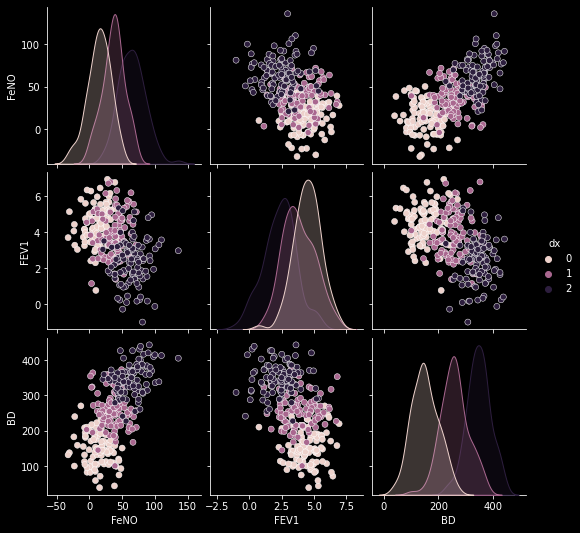

In [75]:
#Exploring dataset:
sns.pairplot(df, kind="scatter", hue="dx")
plt.show()

<AxesSubplot:xlabel='dx', ylabel='FEV1'>

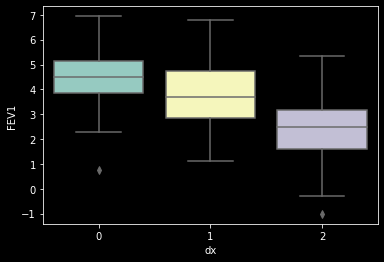

In [76]:
sns.boxplot(x=df["dx"], y=df["FEV1"])

<AxesSubplot:xlabel='dx', ylabel='FeNO'>

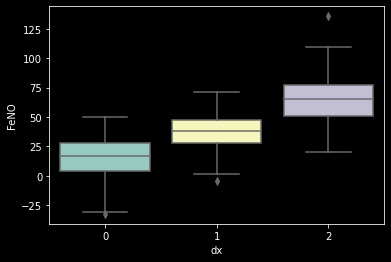

In [77]:
sns.boxplot(x=df["dx"], y=df["FeNO"])

<AxesSubplot:xlabel='dx', ylabel='BD'>

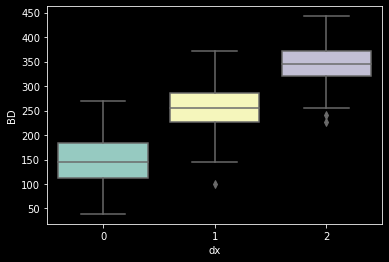

In [78]:
sns.boxplot(x=df["dx"], y=df["BD"])

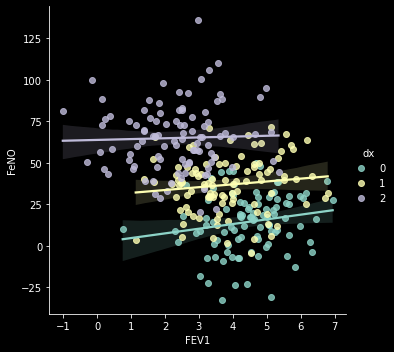

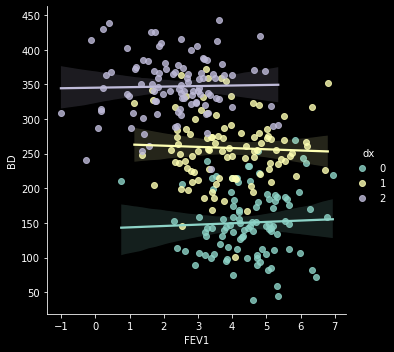

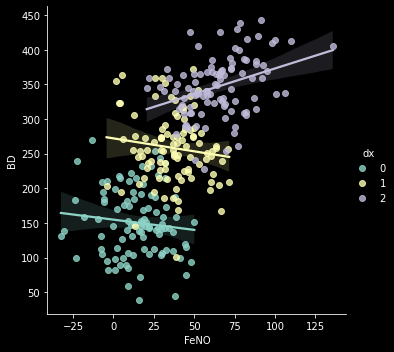

In [79]:
sns.lmplot(x="FEV1", y="FeNO", data=df, fit_reg=True, hue='dx', legend=True)
sns.lmplot(x="FEV1", y="BD", data=df, fit_reg=True, hue='dx', legend=True)
sns.lmplot(x="FeNO", y="BD", data=df, fit_reg=True, hue='dx', legend=True)

|\It is not entirely clear, but so far, and by visual inspection, the variables “FeNO” and “BD” seem to be best to differentiate between the three groups.

In [80]:
#Creating X and y:
X = df.drop('dx', axis=1)
y = df['dx']
#Data split into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [81]:
#Fit Logistic Regression model:
logisticregression = LogisticRegression().fit(X_train, y_train)
#Evaluate Logistic Regression model:
print("training set score: %f" % logisticregression.score(X_train, y_train))
print("test set score: %f" % logisticregression.score(X_test, y_test))
print("coefficients shape: ", logisticregression.coef_.shape)
print("intercept shape: ", logisticregression.intercept_.shape)

training set score: 0.861905
test set score: 0.944444
coefficients shape:  (3, 3)
intercept shape:  (3,)


C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [83]:
logisticregression.coef_

array([[-8.72565326e-02,  6.70883053e-01, -4.18374743e-02],
       [-1.91467535e-04, -5.17736563e-02,  1.04115223e-03],
       [ 8.74480001e-02, -6.19109397e-01,  4.07963220e-02]])

In [84]:
logisticregression.intercept_

array([ 10.03987413,   2.21030906, -12.25018319])

The coefficients shape of (3, 3) means that we have 3 classes and 3 features. The intercept shape is a constant that is added to the decision function, and is the same as the number of classes.

Test accuracy should not be higher than train since the model is optimized for the latter. Ways in which this behavior might happen:

you did not use the same source dataset for test. You should do a proper train/test split in which both of them have the same underlying distribution. Most likely you provided a completely different (and more agreeable) dataset for test

# The C parameter:

The C value in Logistic Regression is an user adjustable parameter that controls regularisation. In simple terms, higher values of C will instruct our model to fit the training set as best as possible, while lower C values will favour a simple models with coefficients closer to zero.

Regularization refers to techniques that are used to calibrate machine learning models in order to minimize the adjusted loss function and prevent overfitting or underfitting. Using Regularization, we can fit our machine learning model appropriately on a given test set and hence reduce the errors in it.

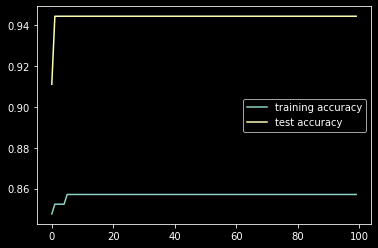

In [85]:
training_accuracy = []
test_accuracy = []
# try c values from 0.001 to 100:
c_settings = np.arange(0.001, 100, 1)
for i in c_settings:
    # build the model
    clf = LogisticRegression(C=i, multi_class='auto',max_iter=900)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.legend()

multi_class='auto' is not giving good results because the scores does not change much with different c values. 
The model is underfitted, check the test accuracy is always 93% close to 1 whule train score 85%. Regardless of the value of C. 

In [86]:
len(c_settings)

100

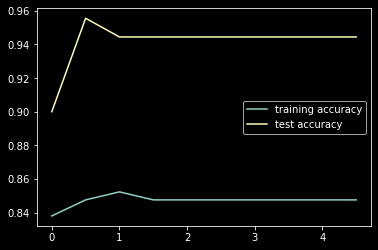

In [91]:
training_accuracy = []
test_accuracy = []
# try c values from 0.001 to 5:
c_settings = np.arange(0.001, 5, 0.5)
for i in c_settings:
    # build the model
    clf = LogisticRegression(C=i, multi_class='ovr', max_iter=1000)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.legend()

Best C value = 1. 

In [88]:
clf = LogisticRegression(C=1, multi_class='ovr', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, multi_class='ovr')

In [89]:
clf.score(X_train, y_train)

0.8523809523809524

In [90]:
clf.score(X_test, y_test)

0.9444444444444444

The C value is not enough in this case to help us in order to avoid having and underfitted model. 

Now we can build a graphical visualisation for our model with the decision boundaries. As 2D are easiest to interpret, we will only use two features to build the graph. During EDA, we found that FeNO and BD were the variables with stronger differentiation power.

Without splitting the data into training and testing. 

0.8666666666666667


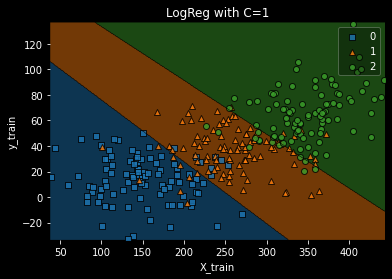

In [92]:
def logisticReg_comparison(data,c):
    x = df[['BD','FeNO',]].values
    y = df['dx'].astype(int).values
    LogReg = LogisticRegression(C=c, multi_class='multinomial',
                                                      max_iter=1000)
    LogReg.fit(x,y)
    print(LogReg.score(x,y))
    #Plot decision region:
    plot_decision_regions(x,y, clf=LogReg, legend=1)
    #Adding axes annotations:
    plt.xlabel('X_train')
    plt.ylabel('y_train')
    plt.title('LogReg with C='+str(c))
    plt.show()
logisticReg_comparison(df,1)

# Iris Dataset second way to do it: 

In [93]:
iris

sepal_length  sepal_width  petal_length  petal_width         species
0             4.9          3.0           1.4          0.2     Iris-setosa
1             4.7          3.2           1.3          0.2     Iris-setosa
2             4.6          3.1           1.5          0.2     Iris-setosa
3             5.0          3.6           1.4          0.2     Iris-setosa
4             5.4          3.9           1.7          0.4     Iris-setosa
..            ...          ...           ...          ...             ...
144           6.7          3.0           5.2          2.3  Iris-virginica
145           6.3          2.5           5.0          1.9  Iris-virginica
146           6.5          3.0           5.2          2.0  Iris-virginica
147           6.2          3.4           5.4          2.3  Iris-virginica
148           5.9          3.0           5.1          1.8  Iris-virginica

[149 rows x 5 columns]

In [94]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [95]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  149 non-null    float64
 1   sepal_width   149 non-null    float64
 2   petal_length  149 non-null    float64
 3   petal_width   149 non-null    float64
 4   species       149 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


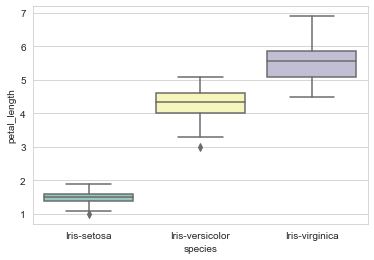

In [96]:
# Creating our first boxplot
sns.set_style('whitegrid')
ax= sns.boxplot(x='species',y='petal_length',data=iris)

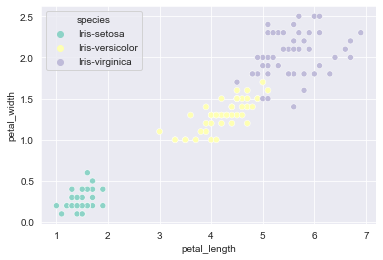

In [97]:
sns.set_style('darkgrid')
ax = sns.scatterplot(x='petal_length', y='petal_width', hue='species', data=iris)

In [98]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
y_encoded=le.fit_transform(iris['species'])

In [99]:
y_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [100]:
X = iris.drop('species', axis=1)

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y_encoded,test_size=0.2)

In [102]:
X_train.shape

(119, 4)

In [103]:
y_train.shape

(119,)

4 features, 3 classes as target values. 

In [104]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

C:\Users\Admin\anacondalastone\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [105]:
y_pred=clf.predict(X_test)

In [106]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test, y_pred, labels=[0,1,2])
cnf_matrix

array([[12,  0,  0],
       [ 0,  9,  0],
       [ 0,  0,  9]], dtype=int64)

In [107]:
y_pred_orig= le.inverse_transform(y_pred)

In [108]:
y_pred_orig

array(['Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-versicolor',
       'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor'], dtype=object)

In [109]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Greens):
   
    import itertools
    
    print('Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure()

Confusion Matrix


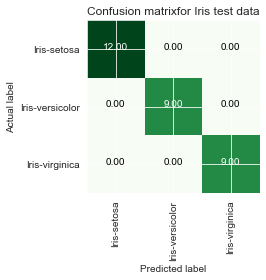

<Figure size 432x288 with 0 Axes>

In [110]:
plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                      title='Confusion matrixfor Iris test data')

In [111]:
#model validation. 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, y_pred)))

Accuracy: 1.00
Error rate: 0.00


perfect score!

# Last example!

In [112]:
# Import data dari CSV
data = pd.read_csv('C:/Users/Admin/Machine Learning chapter 5/car_data.csv')
data.head()

BUYING MAINTENANCE DOORS PERSONS LUGGAGE_BOOT SAFETY  CLASS
0  vhigh       vhigh     2       2        small    low  unacc
1  vhigh       vhigh     2       2        small    med  unacc
2  vhigh       vhigh     2       2        small   high  unacc
3  vhigh       vhigh     2       2          med    low  unacc
4  vhigh       vhigh     2       2          med    med  unacc

In [113]:
data.loc[data['BUYING'] == 'vhigh', 'BUYING'] = 4
data.loc[data['BUYING'] == 'high', 'BUYING'] = 3
data.loc[data['BUYING'] == 'med', 'BUYING'] = 2
data.loc[data['BUYING'] == 'low', 'BUYING'] = 1
data.loc[data['MAINTENANCE'] == 'vhigh', 'MAINTENANCE'] = 4
data.loc[data['MAINTENANCE'] == 'high', 'MAINTENANCE'] = 3
data.loc[data['MAINTENANCE'] == 'med', 'MAINTENANCE'] = 2
data.loc[data['MAINTENANCE'] == 'low', 'MAINTENANCE'] = 1
data.loc[data['DOORS'] == '5more', 'DOORS'] = 5
data.loc[data['PERSONS'] == 'more', 'PERSONS'] = 5
data.loc[data['LUGGAGE_BOOT'] == 'big', 'LUGGAGE_BOOT'] = 3
data.loc[data['LUGGAGE_BOOT'] == 'med', 'LUGGAGE_BOOT'] = 2
data.loc[data['LUGGAGE_BOOT'] == 'small', 'LUGGAGE_BOOT'] = 1
data.loc[data['SAFETY'] == 'high', 'SAFETY'] = 3
data.loc[data['SAFETY'] == 'med', 'SAFETY'] = 2
data.loc[data['SAFETY'] == 'low', 'SAFETY'] = 1
data.loc[data['CLASS'] == 'unacc', 'CLASS'] = 0
data.loc[data['CLASS'] == 'acc', 'CLASS'] = 1
data.loc[data['CLASS'] == 'good', 'CLASS'] = 2
data.loc[data['CLASS'] == 'vgood', 'CLASS'] = 3
data = data.apply(pd.to_numeric, errors='coerce')
data.head()

BUYING  MAINTENANCE  DOORS  PERSONS  LUGGAGE_BOOT  SAFETY  CLASS
0       4            4      2        2             1       1      0
1       4            4      2        2             1       2      0
2       4            4      2        2             1       3      0
3       4            4      2        2             2       1      0
4       4            4      2        2             2       2      0

In [114]:
X = data.iloc[:, [0,1,2,3,4,5]].values  # Independent Feature
y = data.iloc[:, -1].values             # Dependent Feature

In [115]:
X.shape, y.shape

((1728, 6), (1728,))

In [116]:
y

array([0, 0, 0, ..., 0, 2, 3], dtype=int64)

In [117]:
# numpy array
unique, frequency = np.unique(y,
                              return_counts = True)

For this case we have 4 classes. 

In [118]:
unique, frequency

(array([0, 1, 2, 3], dtype=int64),
 array([1210,  384,   69,   65], dtype=int64))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

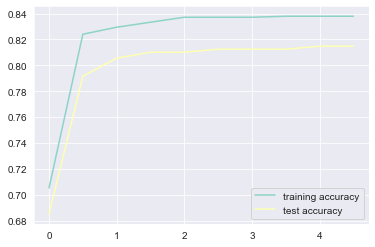

In [120]:
training_accuracy = []
test_accuracy = []
# try c values from 0.001 to 5:
c_settings = np.arange(0.001, 5, 0.5)
for i in c_settings:
    # build the model
    clf = LogisticRegression(C=i, multi_class='ovr', max_iter=1000)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.legend()

#the best C value seems to be around 0.5

In [121]:
clf = LogisticRegression(C=0.5, multi_class='ovr', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=1000, multi_class='ovr')

In [122]:
clf.score(X_train, y_train)

0.8240740740740741

In [124]:
clf.score(X_test, y_test)

0.7916666666666666

In [125]:
y_pred=clf.predict(X_test)

In [133]:
cnf_matrix=confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
cnf_matrix

array([[283,  13,   0,   0],
       [ 42,  55,   2,   0],
       [  2,  17,   2,   0],
       [  0,  14,   0,   2]], dtype=int64)

In [134]:
clf.classes_

array([0, 1, 2, 3], dtype=int64)

In [135]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Greens):
   
    import itertools
    
    print('Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure()

Confusion Matrix


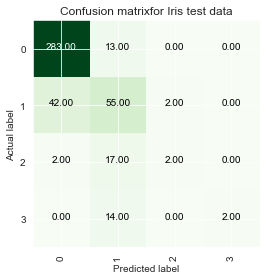

<Figure size 432x288 with 0 Axes>

In [136]:
plot_confusion_matrix(cnf_matrix, classes=clf.classes_,
                      title='Confusion matrixfor Iris test data')